<a href="https://www.kaggle.com/code/johnycoder/ftir-analysis?scriptVersionId=180776080" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [60]:
import pandas as pd, glob, scipy as sci, pandas as pd, numpy as np, copy, time, os
from matplotlib import pyplot as plt
from numpy import pi,cos,exp,square, sqrt, imag, shape
from scipy.special import wofz
from scipy.constants import c, h, e
from scipy.signal import find_peaks
from matplotlib.animation import FuncAnimation
py_blue = '#1f77b4' 
py_orange = '#ff7f0e' 
py_green = '#2ca02c'
py_red = '#d62728'

# Loading data

In [30]:
# reading and sorting files into reference and transmission data
data_files = glob.glob('/kaggle/input/ftir-thin-film/*.dpt')
temp = [x for x in data_files if '0_reflx.' in x]
reflx_data = [temp[0], temp[3], temp[1], temp[2]]
reflx_glass = pd.read_csv([x for x in data_files if 'glass_reflx' in x][0])
reflx_refr = pd.read_csv([x for x in data_files if 'refr_reflx.' in x][0])
temp = [x for x in data_files if '0_trans' in x]
trans_data = [temp[3], temp[1], temp[0], temp[2]]
trans_refr = pd.read_csv([x for x in data_files if 'refr_reflx' in x][0])
trans_glass = pd.read_csv([x for x in data_files if 'glass_trans' in x][0])

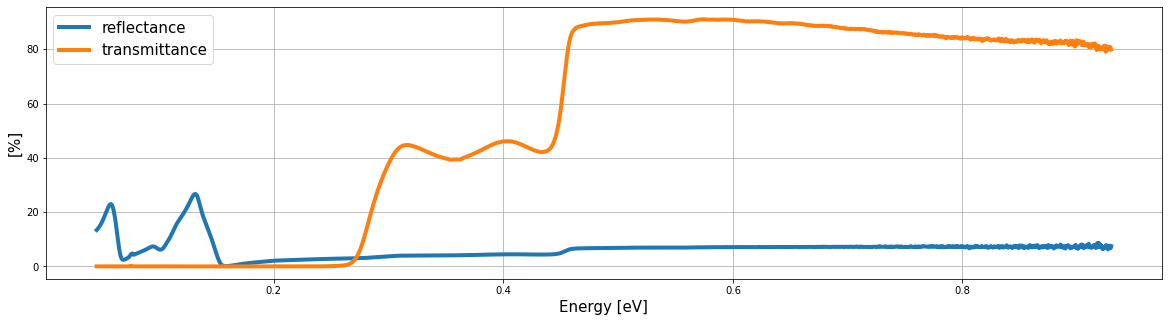

In [31]:
fig = plt.figure(figsize=(20,5))
parcelation = 1 # reducinf number of points
yreflx = reflx_glass.iloc[:,1] / reflx_refr.iloc[:,1] 
yreflx = yreflx[::parcelation]
x = reflx_glass.iloc[:,0]
x = x[::parcelation]
plt.plot(x, yreflx*100, label = 'reflectance', linewidth = 4)

ytrans = trans_glass.iloc[:,1] / trans_refr.iloc[:,1] 
ytrans = ytrans[::parcelation]
plt.plot(x, ytrans*100, label = 'transmittance', linewidth = 4)

plt.xlabel('Energy [eV]', fontsize = 15)
plt.ylabel('[%]', fontsize = 15)
plt.legend(fontsize = 15)
plt.grid()
plt.show()

# Dielectric function

The general form of an oscillator model is given by:
$
\large \varepsilon (\omega) = \varepsilon_{\infty} + \sum_{j} \chi_{j}
$
where
* $\varepsilon$ is the relative permittivity,
* $\varepsilon_{\infty}$ is the value of the relative permittivity at infinite frequency,
* $\omega$ is the angular frequency,
* $\chi_{j}$ is the contribution from the $j$th absorption mechanism oscillator.

Since a glass substrate was investigated here, Lorentzian oscillators were used at the begining. The absorption rise in Transmittance proved to be too abrupt to be described by Lorentzian oscillators, so Brendel-Borman oscillators had to be used.

The Brendel-Bormann oscillator is related to the Lorentzian oscillator ($\chi^{L}$) and Gaussian oscillator ($\chi^{G}$), given by:

$
\large \chi_{j}^{L}(\omega; \omega_{0,j}) = \frac{s_{j}}{\omega_{0,j}^{2} - \omega^{2} - i\Gamma_{j}\omega}
$

$
\large \chi_{j}^{G}(\omega) = \frac{1}{\sqrt{2\pi} \sigma_{j}} \exp \left[-\left(\frac{\omega}{\sqrt{2} \sigma_{j}}\right)^{2}\right]
$

where
* $s_{j}$ is the Lorentzian strength of the $j$th oscillator,
* $\omega_{0,j}$ is the Lorentzian resonant frequency of the $j$th oscillator,
* $\Gamma_{j}$ is the Lorentzian broadening of the $j$th oscillator,
* $\sigma_{j}$ is the Gaussian broadening of the $j$th oscillator.

The Brendel-Bormann oscillator ($\chi^{BB}$) is obtained from the convolution of the two aforementioned oscillators in the manner of:

$
\large \chi_{j}^{BB}(\omega) = \int_{-\infty}^{\infty} \chi_{j}^{G}(x-\omega_{0,j}) \chi_{j}^{L}(\omega; x) \, dx
$

which yields:

$
\large \chi_{j}^{BB}(\omega) = \frac{i \sqrt{\pi} s_{j}}{2 \sqrt{2} \sigma_{j} a_{j}(\omega)} \left[w\left(\frac{a_{j}(\omega) - \omega_{0,j}}{\sqrt{2} \sigma_{j}}\right) + w\left(\frac{a_{j}(\omega) + \omega_{0,j}}{\sqrt{2} \sigma_{j}}\right)\right]
$

where
* $w(z)$ is the Faddeeva function,
* $a_{j} = \sqrt{\omega^2 + i\Gamma_{j}\omega}$.

The square root in the definition of $a_{j}$ must be taken such that its imaginary component is positive. This is achieved by:

$
\large \Re(a_{j}) = \omega \sqrt{\frac{\sqrt{1 + (\Gamma_{j}/\omega)^{2}} + 1}{2}}
$

$
\large \Im(a_{j}) = \omega \sqrt{\frac{\sqrt{1 + (\Gamma_{j}/\omega)^{2}} - 1}{2}}
$

https://en.wikipedia.org/wiki/Brendel%E2%80%93Bormann_oscillator_model

In [32]:
def hobb(param,Energ):
    #  Dielectric function calculation - Harmonic Oscilator Brendel, Bormann
    #  input parameters:  vector [A, E0, Gamma, Sigma]
    #      E - photon energy [eV]
    # output parameters:  Complex dielectric function 
    #                           - vector corresponding to Energy
    #                           - imaginary part is negative
    num_oscilators = int(len(param)/4)
    param = param.reshape(num_oscilators,4).transpose() 
    Energ = np.array(Energ)
    Energ = np.tile(Energ, (num_oscilators,1)).transpose()
    A=param[0]
    E0=param[1]
    Γ=param[2]
    σ=param[3]
    π = pi
    
    ak = sqrt(Energ**2+1j*Energ*Γ)
    ak[ak == 1j*0] = 0.000001*1j
    assert (imag(ak)>0).all
    result = 1j*sqrt(pi/2)*A/2/σ/ak
    permitivity = result * (wofz((ak-E0)/sqrt(2)/σ) + wofz((ak+E0)/sqrt(2)/σ))
    permitivity = np.sum(permitivity, axis =1)
    return permitivity


# Transmittance and Reflectance of thick layer

Considering internal reflection in a thick layer we can write Transmittance as:

$ \Large T^{(012)} = \frac{T^{(01)}T^{(12)}e^{-2k_0 \Im(n) d}}{1 - R^{(01)}R^{(10)}e^{-4 k_0 \Im(n) d}} $

and Reflectance as:

$ \Large R^{(012)} = R^{(01)} + \frac{T^{(01)}R^{(12)}T^{(10)}e^{-4k_{0} \Im(n) d}}{1 - R^{(01)}R^{(10)}e^{-4k_0 \Im(n) d}} $

where T and R are Reflectance and Transmittance on interface obtained from Fresnel coefficients

In [33]:
def thick_layer(p, energy, R, T):
    thickness = p[-1]
    epsilon_inf = p[-2]
    permitivity = hobb(p[:-2], energy) + epsilon_inf
    wavelength = h * c / energy / e
    
    Rdiff = thick_reflect(wavelength, permitivity, thickness) - R
    Tdiff = thick_trans(wavelength, permitivity, thickness) - T
    return np.concatenate((Tdiff, Rdiff))

def thick_reflect(wavelength, permitivity, d):
    n_substrate = np.sqrt(permitivity)
    extinct = np.imag(n_substrate)
    
    R_01 = square(abs((1 - n_substrate)/(1 + n_substrate)))
    R_12 = square(abs((n_substrate - 1)/(n_substrate + 1)))
    T_01 = square(abs(2/(1+n_substrate)))
    T_10 = square(abs(2*n_substrate/(1+n_substrate)))
    exponent = exp(-8*pi/wavelength*extinct*d)
    return R_01 + T_01*R_12*T_10*exponent/(1-square(R_12)*exponent)

def thick_trans(wavelength, permitivity, d):
    n_substrate = np.sqrt(permitivity)
    extinct = np.imag(n_substrate)
    
    R_12 = square(abs((n_substrate - 1)/(n_substrate + 1)))
    T_01 = square(abs(2/(1+n_substrate)))
    T_12 = square(abs(2*n_substrate/(1+n_substrate)))
    exponent1 = exp(-4*pi/wavelength*extinct*d)
    exponent2 = exp(-8*pi/wavelength*extinct*d)
    Trans = T_01*T_12*exponent1/(1-square(R_12)*exponent2) 
    return Trans

# Fitting substrate

In [34]:
init_params = []
init_params.extend([0.001,0.06,0.001,0.008,
                    0.001,0.07,0.001,0.008,
                    0.001,0.10,0.001,0.008,
                    0.002,0.13,0.004,0.0008,
                    0.001,0.21,0.004,0.0008,
                    0.001,0.26,0.004,0.0008,
                    0.001,0.3,0.004,0.0008,
                    0.0001,0.46,0.0009,0.0008,
                    0.0001,0.53,0.0009,0.0008,
                    0.0001,1,0.0009,0.0008,
                   ])
epsilon_inf = 2.4
init_params.append(epsilon_inf)
d = 0.002
init_params.append(d)
init_params = np.array(init_params)
upper_bounds = np.full(len(init_params)-1, np.inf)
lower_bounds = np.zeros(len(init_params)-1)
bounds = [(np.append(lower_bounds,(0.0005))),(np.append(upper_bounds,(0.6)))]

from scipy.optimize import least_squares
start_time = time.time()
thick_res = least_squares(thick_layer,x0=init_params, args=(x, yreflx, ytrans), bounds = bounds, max_nfev = 1000)
end_time = time.time()

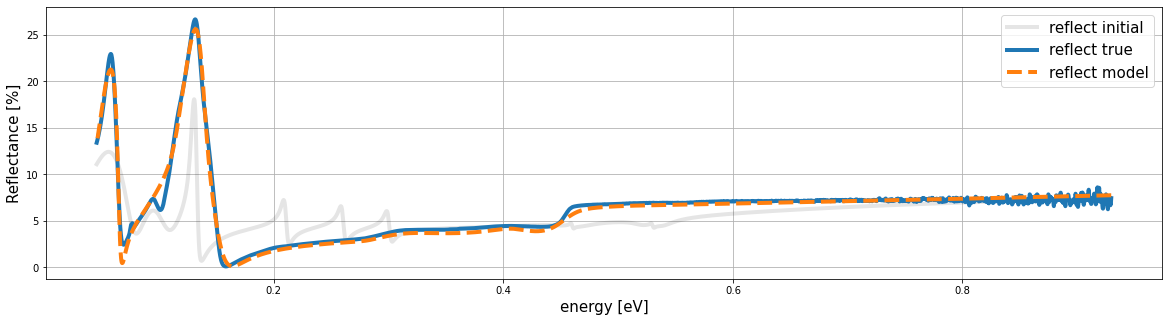

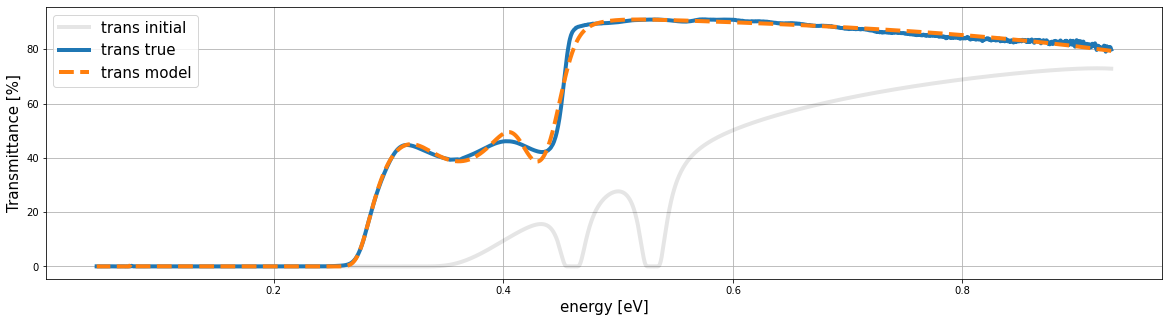

,A,E_0,$\Gamma$,$\sigma$
0,1.79e-03,5.73e-02,2.69e-11,4.56e-03
1,3.87e-03,1.27e-01,3.21e-11,5.67e-03
2,3.05e-06,3.62e-01,9.10e-08,4.38e-02
3,5.42e-05,2.20e-01,5.59e-05,2.26e-02
4,2.24e-06,2.68e-01,1.59e-03,2.78e-02
5,2.28e-07,2.11e-01,2.74e-05,5.04e-03
6,4.57e-03,1.32e-01,3.63e-11,1.50e-02
7,6.88e-07,4.32e-01,2.78e-12,1.38e-02
8,1.10e-09,2.08e-03,1.08e-02,1.45e+00
9,9.68e-01,1.49e+00,1.62e-05,4.45e-02


substrate thickness = 5.61 mm
Ɛ∞ =                  1.68


cost:                 0.34
numer of evaluations: 143
time of fit:          89 s


In [35]:
guess_permitivity = hobb(init_params[:-2], x) + init_params[-2]
permitivity = hobb(thick_res.x[:-2], x) + thick_res.x[-2]
wavelengths = h * c / x / e

#plotting reflectance
fig = plt.figure(figsize=(20,5))
plt.plot(x, thick_reflect(wavelengths, guess_permitivity, init_params[-1])*100, label='reflect initial', alpha=0.1, color='black', linewidth = 4)
plt.plot(x, yreflx*100, label='reflect true', linewidth = 4)
plt.plot(x, thick_reflect(wavelengths, permitivity, thick_res.x[-1])*100, label = 'reflect model', linestyle = 'dashed', linewidth = 4)
plt.xlabel('energy [eV]', fontsize = 15)
plt.ylabel('Reflectance [%]', fontsize = 15)
plt.legend(fontsize=15)
plt.grid()
plt.show()

#plotting transmittance
fig = plt.figure(figsize=(20,5))
plt.plot(x, thick_trans(wavelengths, guess_permitivity, init_params[-1])*100,label='trans initial', alpha=0.1, color = 'black', linewidth = 4)
plt.plot(x, ytrans*100, label='trans true', linewidth = 4)
plt.plot(x, thick_trans(wavelengths, permitivity, thick_res.x[-1])*100, label = 'trans model',linestyle = 'dashed', linewidth = 4)
plt.xlabel('energy [eV]', fontsize = 15)
plt.ylabel('Transmittance [%]', fontsize = 15)
plt.legend(fontsize=15)
plt.grid()
plt.show()

data = thick_res.x[:-2]

# Display fitted parameters
data = data.reshape(-1, 4)
d_glass = thick_res.x[-1]
df = pd.DataFrame(data, columns=["A", "E_0", "$\Gamma$", "$\sigma$"])
pd.set_option('display.float_format', '{:.2e}'.format)
display(df)
print('substrate thickness = ' + str(round(d_glass*1000, 2)) + ' mm')
print("Ɛ∞ =                  " + str(round(thick_res.x[-2], 2)) )
print('\n')
print('cost:                 ' + str(round(thick_res.cost, 2)))
print('numer of evaluations: ' + str(thick_res.nfev))
print('time of fit:          ' + str(round(end_time - start_time)) + ' s')


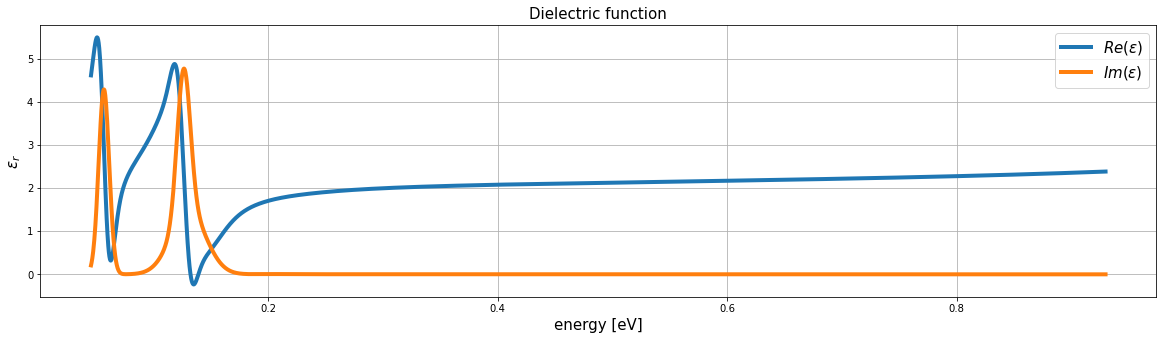

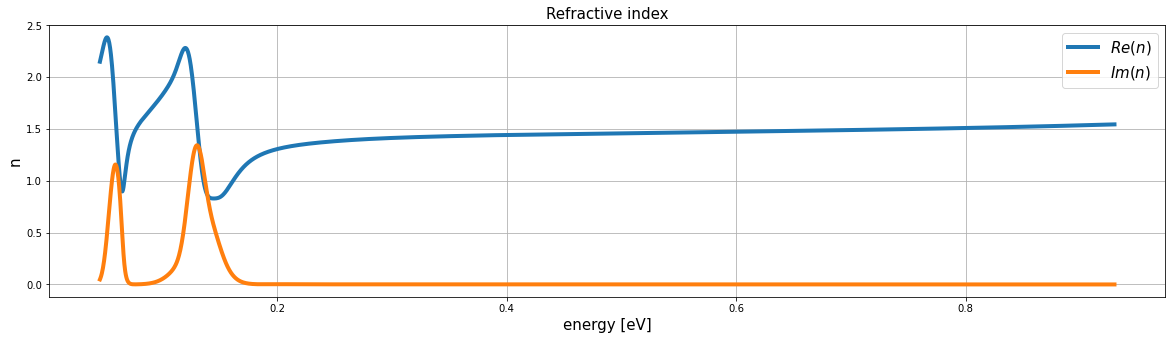

In [36]:
n_glass = np.sqrt(permitivity)
#plotting dielectric function
fig = plt.figure(figsize=(20,5))
plt.plot(x, np.real(permitivity), label='$Re(\epsilon)$', linewidth = 4)
plt.plot(x, np.imag(permitivity), label='$Im(\epsilon)$', linewidth = 4)
plt.legend(fontsize = 15)
plt.grid()
plt.xlabel("energy [eV]", fontsize = 15)
plt.ylabel("$\epsilon_r$", fontsize = 15)
plt.title('Dielectric function', fontsize = 15)
plt.savefig('Dielectric.png')

# plotting refractive index
fig = plt.figure(figsize=(20,5))
plt.plot(x, np.real(n_glass), label='$Re(n)$', linewidth = 4)
plt.plot(x, np.imag(n_glass), label='$Im(n)$', linewidth = 4)
plt.legend(fontsize = 15)
plt.grid()
plt.xlabel("energy [eV]", fontsize = 15)
plt.ylabel("n", fontsize = 15)
plt.title('Refractive index', fontsize = 15)
plt.savefig('Refractive.png')

# Thin layer functions

$ \Large t_{012}^{s,p} = \frac{t_{01}^{s,p} t_{12}^{s,p} e^{-i k_z d}}{1 - r_{s,p} \tilde{r}_{s,p} e^{-i 2k_z d}}$

$ \Large r_{012}^{s,p} = \frac{r_{01}^{s,p} + r_{12}^{s,p} e^{-i 2 k_z d}}{1 + r_{01}^{s,p} r_{12}^{s,p} e^{-i 2 k_z d}}$


using infinite summation of geometric series to express multiple beam interference as seen 

![](http://www.jawoollam.com/wp-content/uploads/optical-interference-for-a-thin-film-on-substrate.png)

In [37]:
def r_interference(wavelengths, n_sub, n_sup, d_sup):
    r_01 = (n_sup - 1)/(n_sup+1)
    r_12 = (n_sub - n_sup)/(n_sub+n_sup)
    Reflection = np.square(np.abs((r_01+r_12*exp(-4j*pi/wavelengths*n_sup*d_sup))/(1 + r_01*r_12*exp(-4j*pi/wavelengths*n_sup*d_sup))))
    return Reflection

def r_interference_back(wavelengths, n_sub, n_sup, d_sup):
    r_01 = (n_sup - n_sub)/(n_sub+n_sup)
    r_12 = (1 - n_sup)/(n_sup+1)
    Reflection = np.square(np.abs((r_01+r_12*exp(-4j*pi/wavelengths*n_sup*d_sup))/(1 + r_01*r_12*exp(-4j*pi/wavelengths*n_sup*d_sup))))
    return Reflection

def t_interference(wavelengths, n_sub, n_sup, d_sup):
    r_01 = (1 - n_sup)/(n_sup+1)
    r_12 = (n_sup - n_sub)/(n_sub+n_sup)
    t_01 = 2/(n_sup+1)
    t_12 = 2*n_sup/(n_sup+n_sub)
    T = np.square(np.abs((t_01*t_12*exp(-2j*pi/wavelengths*n_sup*d_sup))/(1 + r_01*r_12*exp(-4j*pi/wavelengths*n_sup*d_sup))))
    return T

def t_interference_back(wavelengths, n_sub, n_sup, d_sup):
    r_01 = (1 - n_sup)/(n_sup+1)
    r_12 = (n_sup - n_sub)/(n_sub+n_sup)
    t_01 = 2*n_sub/(n_sub+n_sup)
    t_12 = 2*n_sup/(n_sup+1)
    T = np.square(np.abs((t_01*t_12*exp(-2j*pi/wavelengths*n_sup*d_sup))/(1 + r_01*r_12*exp(-4j*pi/wavelengths*n_sup*d_sup))))
    return T

def r_substrate(wavelengths, n_sub, n_sup, d_sub, d_sup):
    extinct = np.imag(n_sub)
    
    R_01 = r_interference(wavelengths, n_sub, n_sup, d_sup)
    R_10 = r_interference_back(wavelengths, n_sub, n_sup, d_sup)
    R_12 = square(abs((n_sub - 1)/(n_sub + 1)))
    T_01 = t_interference(wavelengths, n_sub, n_sup, d_sup)
    T_10 = t_interference_back(wavelengths, n_sub, n_sup, d_sup)
    exponent = exp(-4*pi/wavelengths*extinct*d_sub)
    return R_01 + T_01*R_12*T_10*exponent/(1-R_12*R_10*exponent)

def t_substrate(wavelengths, n_sub, n_sup, d_sub, d_sup):
    extinct = np.imag(n_sub)
    R_10 = r_interference_back(wavelengths, n_sub, n_sup, d_sup)
    R_12 = square(abs((n_sub - 1)/(n_sub + 1)))
    T_01 = t_interference(wavelengths, n_sub, n_sup, d_sup)
    T_12 = square(abs(2*n_sub/(1+n_sub)))
    exponent1 = exp(-4*pi/wavelengths*extinct*d_sub)
    exponent2 = exp(-8*pi/wavelengths*extinct*d_sub)
    Trans = T_01*T_12*exponent1/(1-R_12*R_10*exponent2)
    return Trans

def fit_both(p, energy, R1, T1, d1, R2, T2, d2, R3, T3, d3, R4, T4, d4, fit_d, d_sub, n_sub):
    if fit_d: 
        d_sup = p[-4:]
    else:
        d_sup = np.array([d1, d2, d3, d4])
    epsilon_inf = p[-5]
    superstrate_permitivity = hobb(p[:-5],energy) + epsilon_inf
    n_sup = np.sqrt(np.conj(superstrate_permitivity))
    n_sub = n_sub[:len(energy)]
    wavelengths = h * c / energy / e
    
    Rdiff1 = r_substrate(wavelengths, n_sub, n_sup, d_sub, d_sup[0]) - R1
    Tdiff1 = t_substrate(wavelengths, n_sub, n_sup, d_sub, d_sup[0]) - T1
    Rdiff2 = r_substrate(wavelengths, n_sub, n_sup, d_sub, d_sup[1]) - R2
    Tdiff2 = t_substrate(wavelengths, n_sub, n_sup, d_sub, d_sup[1]) - T2
    Rdiff3 = r_substrate(wavelengths, n_sub, n_sup, d_sub, d_sup[2]) - R3
    Tdiff3 = t_substrate(wavelengths, n_sub, n_sup, d_sub, d_sup[2]) - T3
    Rdiff4 = r_substrate(wavelengths, n_sub, n_sup, d_sub, d_sup[3]) - R4
    Tdiff4 = t_substrate(wavelengths, n_sub, n_sup, d_sub, d_sup[3]) - T4
    both = np.concatenate((Tdiff1, Rdiff1, Tdiff2, Rdiff2, Tdiff3, Rdiff3, Tdiff4, Rdiff4))
    return both

# Fitting thin layer

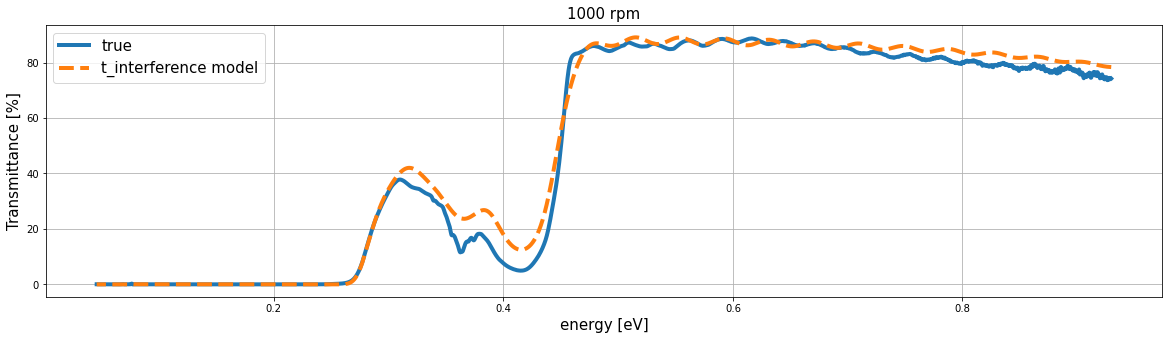

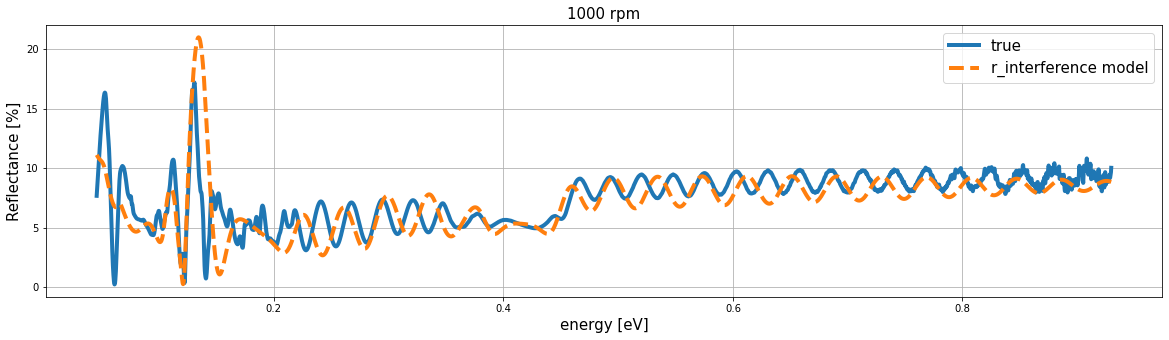

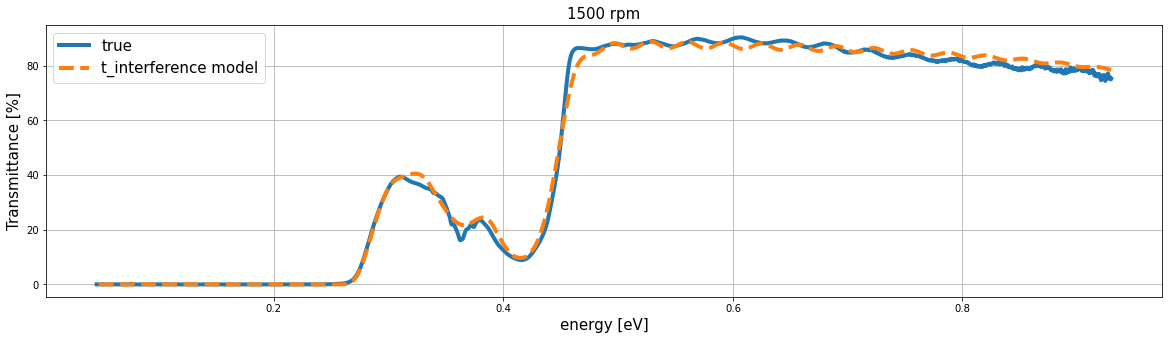

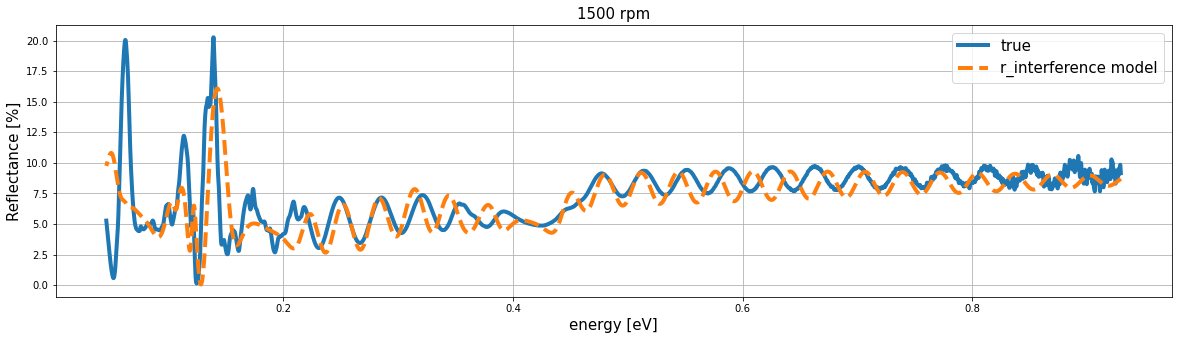

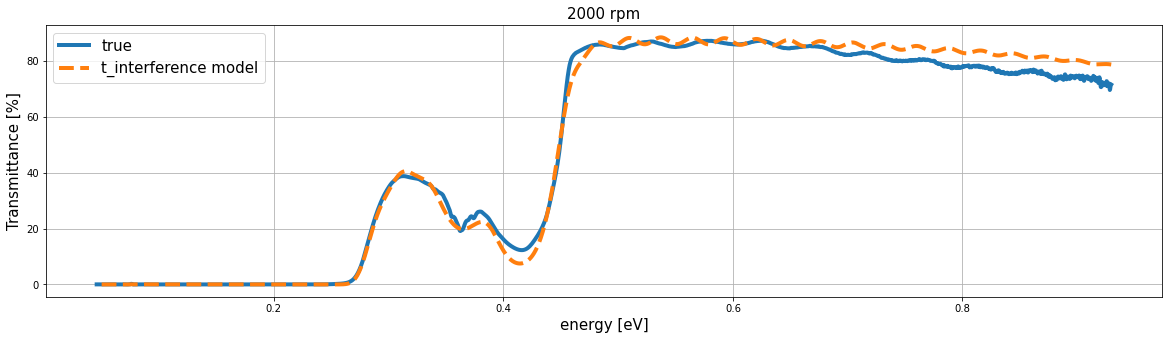

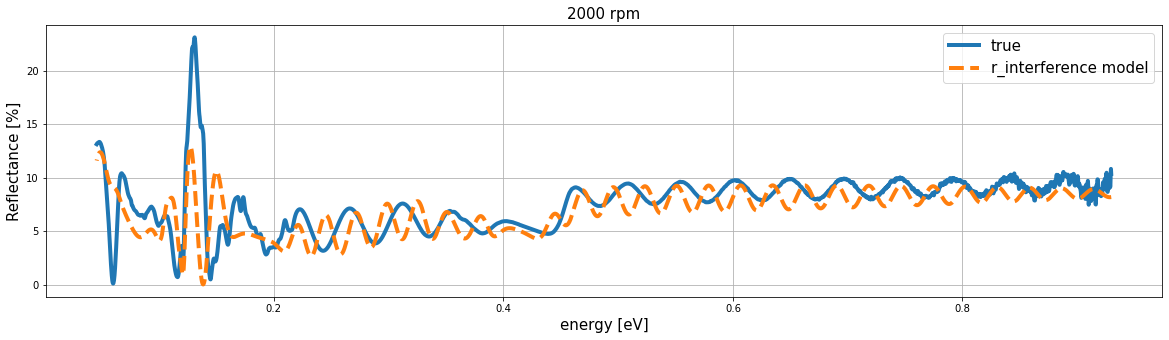

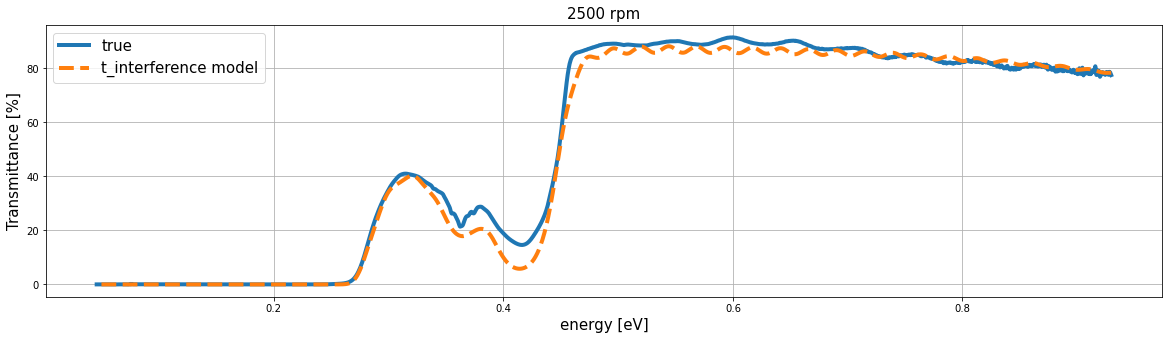

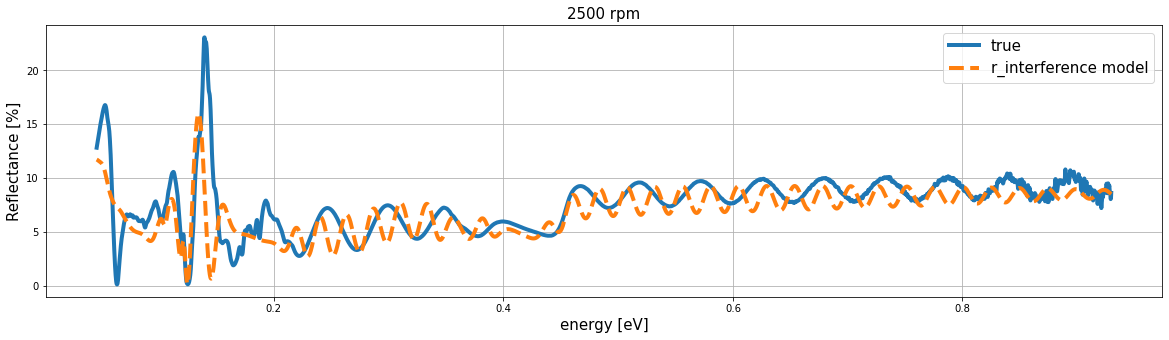

In [38]:
d = np.array([10e-6, 12e-6, 14e-6, 16e-6])# initial guess for glass thicknes
inter_params = [] 
inter_params.extend([0.0001,0.06,0.01,0.008,
                     0.0001,0.07,0.01,0.008,
                     0.0001,0.08,0.01,0.008,
                     0.0001,0.09,0.01,0.008,
                     0.0001,0.10,0.01,0.008,
                     0.0001,0.11,0.01,0.008,
                     0.0001,0.13,0.01,0.008,
                     0.01,0.4,0.01,0.0008,
                     0.005,0.05,0.01,0.08,])
epsilon_inf = 2.4
inter_params.append(epsilon_inf)
inter_params.extend(d)
inter_params = np.array(inter_params)
arguments = [x]
truth = []
for sample in range(4):
    inter_trans = pd.read_csv(trans_data[sample]).iloc[:,1][:]  / trans_refr.iloc[:,1][:] 
    inter_trans = inter_trans[::parcelation]
    inter_reflx = pd.read_csv(reflx_data[sample]).iloc[:,1][:]  / reflx_refr.iloc[:,1][:] 
    inter_reflx = inter_reflx[::parcelation]
    truth.append([inter_reflx, inter_trans])
    arguments.extend([inter_reflx, inter_trans, d[sample]])
arguments.extend([True, d_glass, n_glass])

upper_bounds = np.full(len(inter_params)-1, np.inf)
lower_bounds = np.zeros(len(inter_params)-1)
bounds = [(np.append(lower_bounds,(1e-6))),(np.append(upper_bounds,(0.6)))]


from scipy.optimize import least_squares
thin_res = least_squares(fit_both,x0=inter_params, args=arguments, max_nfev = 100, bounds = bounds)
epsilon_inf = thin_res.x[-5]
rezist_permitivity = hobb(thin_res.x[:-5], x) + epsilon_inf
n_rez = np.sqrt(np.conj(rezist_permitivity))

rpms = [1000, 1500, 2000, 2500]


for sample in range(4):
    inter_reflx, inter_trans = truth[sample]

    inter_init = np.append(inter_params[:-4], d[-sample-1])

    
    fig = plt.figure(figsize=(20,5))
    #plt.plot(x, t_substrate(inter_init[:-1], x, d[sample])*100 , label='t_interference init', color='black', alpha=0.6)
    plt.plot(x, inter_trans*100, label='true', linewidth = 4)
    plt.plot(x, t_substrate(wavelengths, n_glass, n_rez, d_glass, d[sample])*100, label = 't_interference model', linestyle = 'dashed', linewidth = 4)
    plt.xlabel('energy [eV]', fontsize = 15)
    plt.ylabel('Transmittance [%]', fontsize = 15)
    plt.title(str(rpms[sample]) + ' rpm', fontsize = 15)
    plt.legend(fontsize=15)
    plt.grid()

    fig = plt.figure(figsize=(20,5))
    #plt.plot(x, r_substrate(inter_init[:-1], x, d[sample])*100 , label='r_interference init', color='black', alpha=0.6)
    plt.plot(x, inter_reflx*100, label='true', linewidth = 4)
    plt.plot(x, r_substrate(wavelengths, n_glass, n_rez, d_glass, d[sample])*100, label = 'r_interference model', linestyle = 'dashed', linewidth = 4)
    plt.xlabel('energy [eV]', fontsize = 15)
    plt.ylabel('Reflectance [%]', fontsize = 15)
    plt.title(str(rpms[sample]) + ' rpm', fontsize = 15)
    plt.legend(fontsize=15)
    plt.grid()

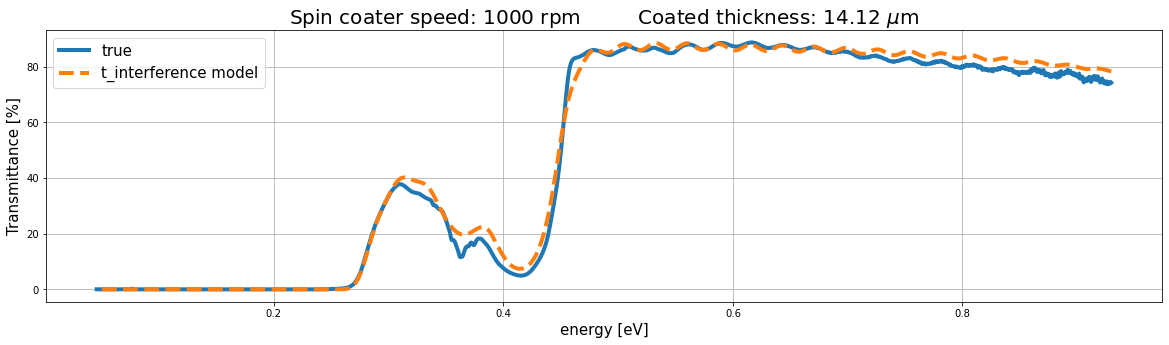

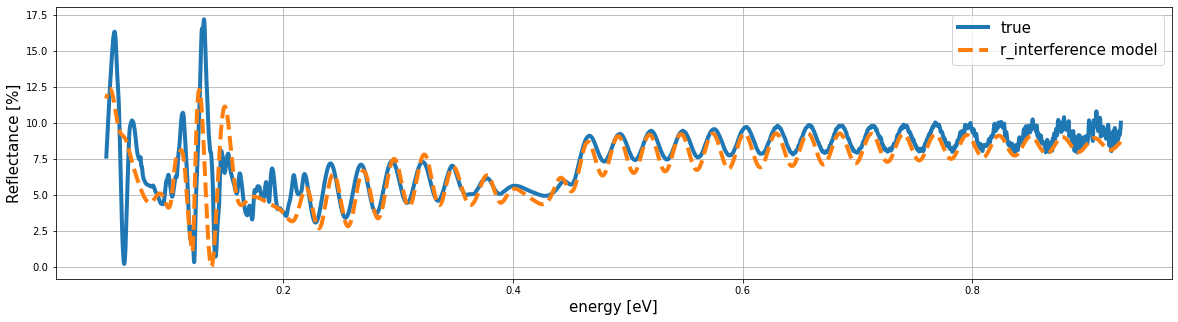

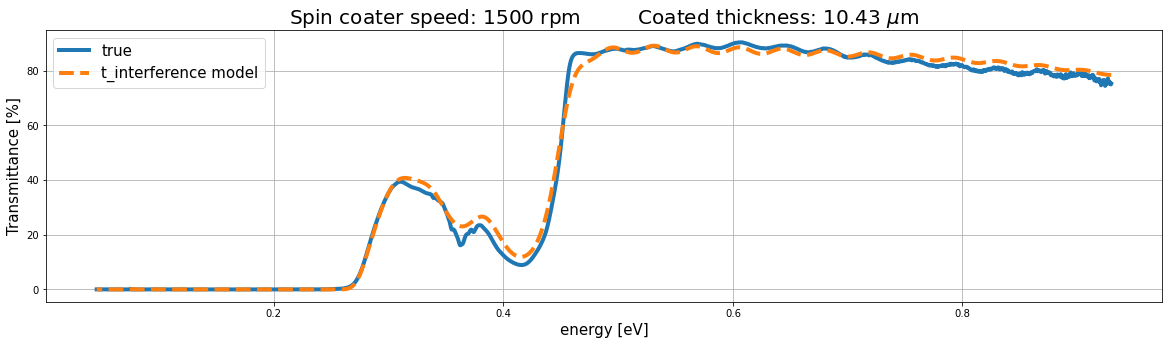

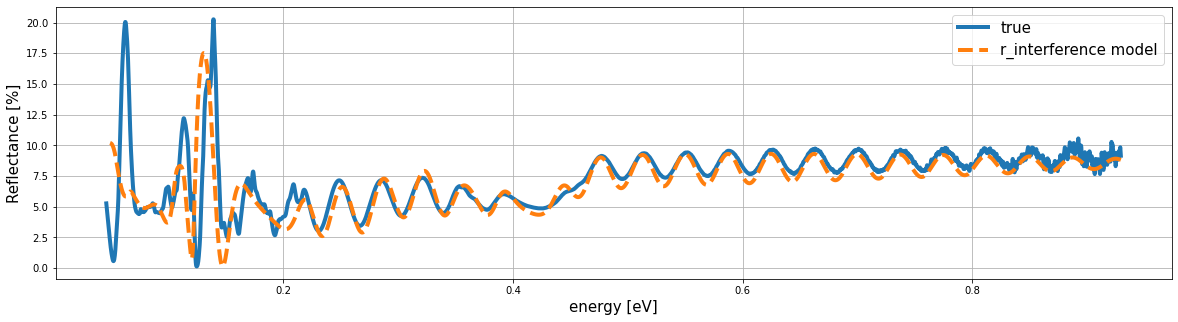

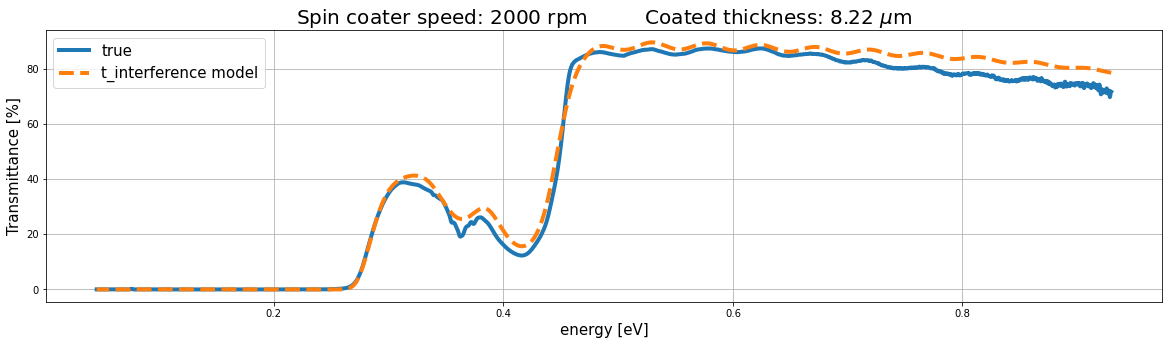

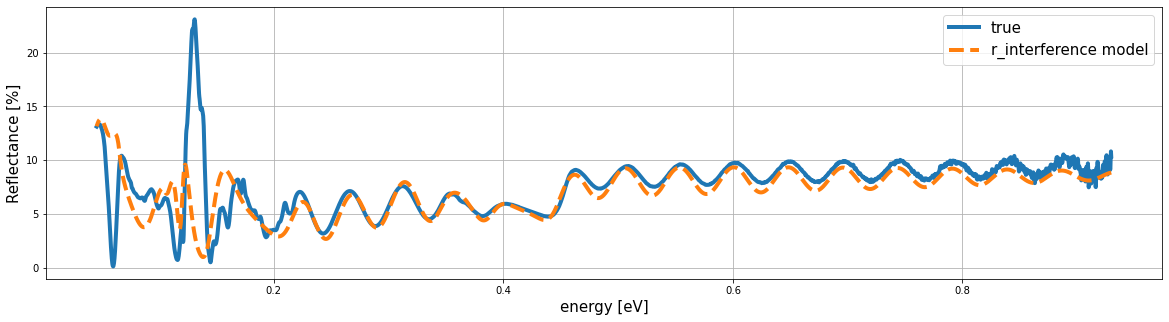

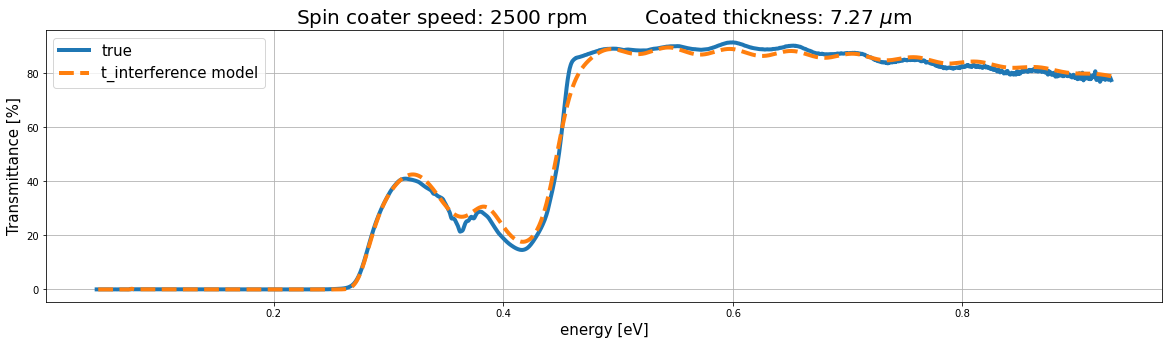

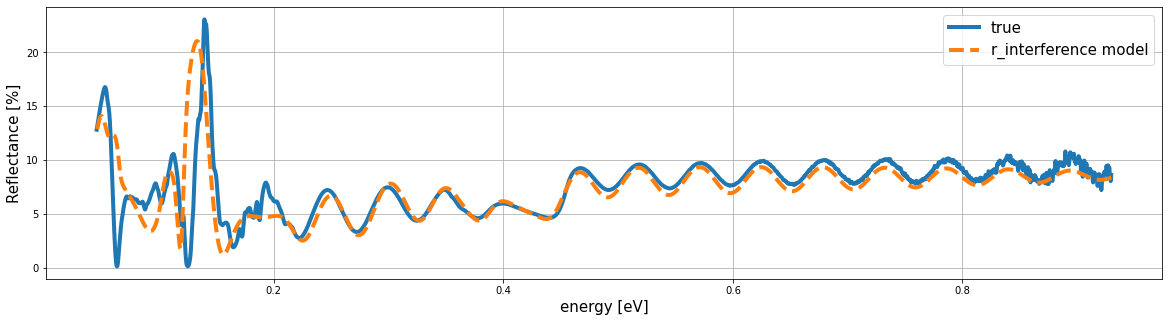

In [39]:
thicknesses = []
for sample in range(4):
    inter_reflx, inter_trans = truth[sample]

    best_difference = np.inf
    best_thickness = 0
    for i in np.arange(5,30,0.01):
        inter_fit = thin_res.x[:-4]
        difference = sum(np.square(r_substrate(wavelengths, n_glass, n_rez, d_glass, i*1e-6)[:3100] - inter_reflx[:3100]))
        if difference < best_difference:
            best_difference = difference
            best_thickness = i
    
    thicknesses.append(best_thickness)
    
    inter_fit = thin_res.x[:-4]
    fig = plt.figure(figsize=(20,5))
    plt.plot(x, inter_trans*100, label='true', linewidth = 4)
    plt.plot(x, t_substrate(wavelengths, n_glass, n_rez, d_glass, best_thickness*1e-6)*100, label = 't_interference model', linestyle = 'dashed', linewidth = 4)
    plt.xlabel('energy [eV]', fontsize = 15)
    plt.ylabel('Transmittance [%]', fontsize = 15)
    plt.title('Spin coater speed: ' + str(rpms[sample]) + ' rpm         Coated thickness: ' + str(round(best_thickness, 2)) + ' $\mu$m', fontsize = 20)
    plt.legend(fontsize=15)
    plt.grid()
    plt.show()


    fig = plt.figure(figsize=(20,5))
    plt.plot(x, inter_reflx*100, label='true', linewidth = 4)
    plt.plot(x, r_substrate(wavelengths, n_glass, n_rez, d_glass, best_thickness*1e-6)*100, label = 'r_interference model', linestyle = 'dashed', linewidth = 4)
    plt.xlabel('energy [eV]', fontsize = 15)
    plt.ylabel('Reflectance [%]', fontsize = 15)
    plt.legend(fontsize=15)
    plt.grid()
    plt.show()

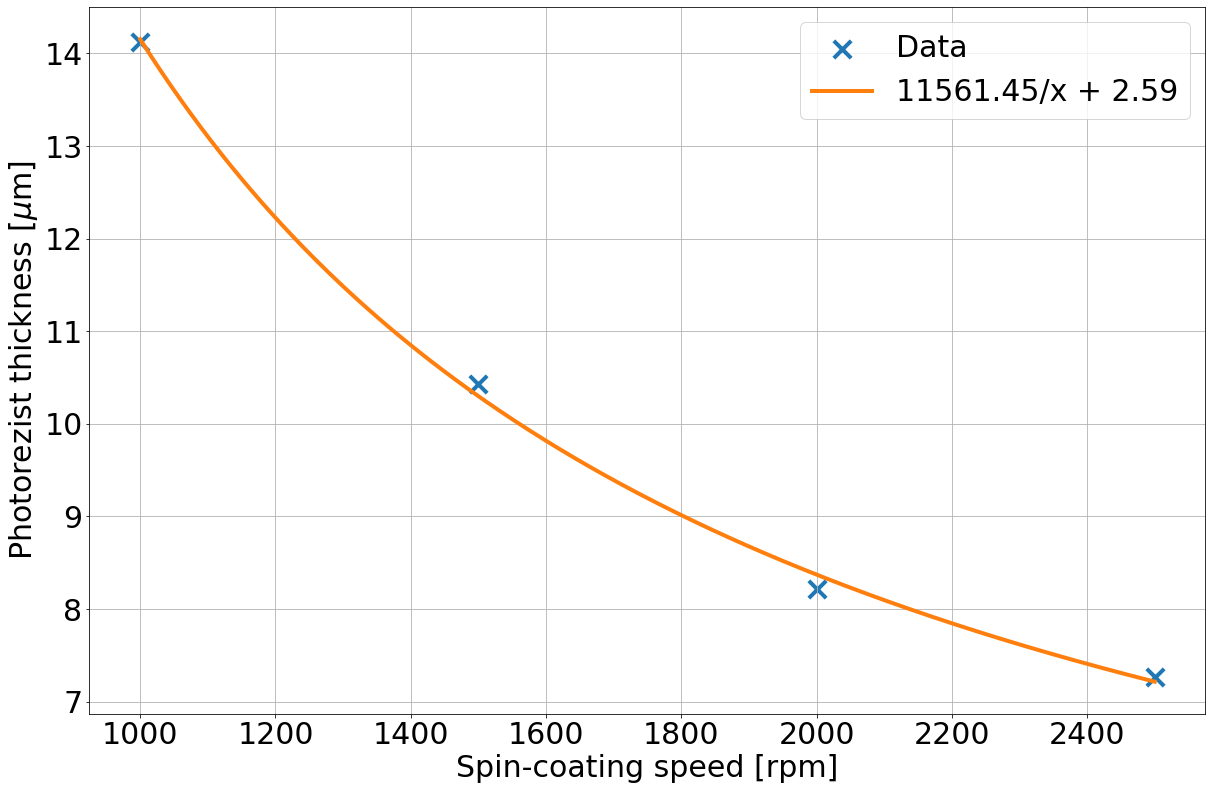

In [65]:
from scipy.optimize import curve_fit
def model(x, a, b):
    return a / x + b

# Fit the model to the data
popt, _ = curve_fit(model, rpms, thicknesses, p0=[1, 0])

# Plotting the data
plt.figure(figsize=(20, 13))
plt.scatter(rpms, thicknesses, marker='x', s=300, label='Data', linewidth = 4)
plt.ylabel('Photorezist thickness [$\mu$m]', fontsize=30)
plt.xlabel('Spin-coating speed [rpm]', fontsize=30)
plt.tick_params(axis='both', which='major', labelsize=30)

# Plotting the fit
x_values = np.linspace(min(rpms), max(rpms), 400)
y_values = model(x_values, *popt)
plt.plot(x_values, y_values, '-', label=f'{popt[0]:.2f}/x + {popt[1]:.2f}', linewidth = 4, color = py_orange)

# Show grid, legend, and plot
plt.grid()
plt.legend(fontsize = 30)
plt.show()


## Brendel Bormann parameters defining resist's permitivity

In [46]:
data = thin_res.x[:-5]

# Display fitted parameters
data = data.reshape(-1, 4)
df = pd.DataFrame(data, columns=["A", "E_0", "$\Gamma$", "$\sigma$"])
pd.set_option('display.float_format', '{:.2e}'.format)
display(df)
print("Ɛ∞ =                  " + str(round(thin_res.x[-5], 2)) )

,A,E_0,$\Gamma$,$\sigma$
0,1.90e-04,5.22e-02,6.27e-06,3.77e-03
1,3.11e-03,6.64e-02,4.46e-02,6.98e-04
2,1.71e-09,7.02e-02,2.57e-02,6.12e-02
3,2.01e-09,6.15e-02,2.36e-02,6.06e-02
4,1.72e-04,5.41e-02,3.93e-02,3.28e-05
5,7.13e-04,1.14e-01,2.64e-05,3.50e-03
6,3.39e-04,3.64e-01,1.05e-02,1.18e-02
7,9.78e-04,4.12e-01,1.55e-09,1.59e-02
8,1.82e-03,1.80e-01,9.38e-04,1.77e-02


Ɛ∞ =                  2.49


# Fancy animation maker

In [ ]:
def update(frame):
    if frame < 1700:  # Normal animation frames
        i = frame / 100.0
        for idx, ax in enumerate(axs.flat):
            ax.clear()
            inter_reflx, inter_trans = truth[idx]
            best_thickness = min(thicknesses[idx], i)
            rpm = rpms[idx]
            ax.plot(x, inter_reflx * 100, label='Data', linewidth=4)
            ax.plot(x, r_substrate(wavelengths, n_glass, n_rez, d_glass, best_thickness * 1e-6) * 100, label='Model', linestyle='dashed', linewidth=4)
            ax.text(0.02, 22.2, f'Spincoater speed: {round(rpm, 2)} RPM', fontsize=17, bbox=dict(facecolor='white', edgecolor='black'))
            ax.text(0.32, 14.5, '                                           ', fontsize = 17, bbox=dict(facecolor='grey', edgecolor='White'))
            ax.text(0.3, 15, f'Coated thickness: {round(best_thickness, 2)} μm', fontsize=17, bbox=dict(facecolor='white', edgecolor='black'))
            ax.grid(True)
            ax.legend(fontsize=15)
            ax.set_ylim(-2, 24)
            ax.set_xlabel('Energy [eV]', fontsize=15)
            ax.set_ylabel('Reflectance [%]', fontsize=15)
    else:  # Final plot frames
        for ax in axs.flat:
            ax.clear()
            ax.set_visible(False)  # Hide all subplots
        fig.clear()  # Clear the entire figure to start fresh for the full plot
        ax = fig.add_subplot(111)  # Create a single subplot that covers the entire figure

        # Now use `ax` to plot, ensuring that all plotting commands apply to this new subplot
        ax.scatter(rpms, thicknesses, marker='x', s=300, label='Data', linewidth=4)
        ax.plot(x_values, y_values, '-', label=f'{popt[0]:.2f}/x + {popt[1]:.2f}', linewidth=4, color='orange')
        ax.set_ylabel('Rezist  thickness [$\mu$m]', fontsize=30)
        ax.set_xlabel('Spin-coating speed [rpm]', fontsize=30)
        ax.tick_params(axis='both', which='major', labelsize=30)
        ax.grid()
        ax.legend(fontsize=30)
        plt.draw()  # Use plt.draw() to refresh the entire plot


# Create the figure and animate
fig, axs = plt.subplots(2, 2, figsize=(20, 13))
ani = FuncAnimation(fig, update, frames=np.arange(300, 1900, 1), repeat=False)

ani.save('output_video.mp4', writer='ffmpeg', fps=60)

plt.show()
